In [94]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

# INTRODUCTION AND OVERVIEW

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. RMS Titanic was a passenger<br> liner that sank in the North Atlantic Ocean in the early morning of 15 April 1912, after colliding with an iceberg. <br>Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making it one of the deadliest<br> commercial peacetime maritime disasters in modern history.  One of the reasons that the shipwreck led to such <br>loss of life was that there were not enough lifeboats for the passengers and crew. 

In this project our goal is to understand what category of passengers were more likely to survive. Our dataset is <br>
a  CSV file that contains demographics and passenger information from 891 of the 2224 passengers and crew on<br>
board the Titanic. 

#### Data Dictionary
---------------------------------------
Let us first look at the variables and their definitions in the dataset. 

| Variable      |   Definition  |          Key              |
| ------------- |:------------- | :------------------------
| survival      | Survival      | 0 = No; 1 = Yes           |
| pclass        | Ticket class  | 1 = 1st; 2 = 2nd; 3 = 3rd |
| sex           | Gender        |                           |
| Age           | Age in years  |                           |
| sibsp         | # of siblings/|                           |
|               | spouses aboard|                           |
|               | the Titanic 
| parch         | # of parents/ |                           |
|               | children on   |                           |
|               | the  Titanic  |                           |
| ticket        | Ticket number |                           |
| fare          | Passenger Fare|                           |
| cabin         | Cabin number  |                           |
| embarked      | Port of Embar-| C = Cherbourg;            |
|               | kation        | Q = Queenstown;           |
|               |               | S = Southampton

#### Variable Notes
----------------------------------------

*pclass*: A proxy for socio-economic status (SES)<br>
1st = Upper<br>
2nd = Middle<br>
3rd = Lower

*age*: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

*sibsp*: <br>
Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)

*parch*: <br>
Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.


## Goal
----------------------------------
The goal of this project is to analyze what factors made passengers more likely to survive. To be more precise, we choose <br>
the outcome variable as *Survival* and choose different variables and understand if any of these factors or their combinations<br> had an effect on the survival of passengers. Let us emphasize that the the goal of this
project is not to pinpoint<br> certain factors as the *cause* for survival but to merely observe which factors made survival more likely.

# Loading and Wrangling Data
-----------------------------------------------------

Let us start by loading the dataset in to a *Pandas* dataframe.

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import csv as csv
import seaborn as sns
%matplotlib inline

url = "https://d17h27t6h515a5.cloudfront.net/topher/2016/September/57e9a84c_titanic-data/titanic-data.csv"
titanic_data = pd.read_csv(url)

Let us view the last few rows of our dataframe.

In [3]:
titanic_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


Notice that *Fare* values are directly related to *Pclass* values. Analyzing the survival data corresponding to <br>
*Pclass* values will be very similar to survival data for *Fare* Values. We can thus safely drop the *Fare* column <br>
from further analysis. *Ticket* is most likely related to *Fare*, *Cabin* and *Class*. We can afford to
drop this column too.

We also observe that there are some NaN values. Let us first see which columns have missing observations. 

In [4]:
missing_observations = titanic_data.columns[titanic_data.isnull().any()]
missing_observations

Index([u'Age', u'Cabin', u'Embarked'], dtype='object')

The columns "Age", "Cabin" and "Embarked" have missing values. Let us now now see how many 
missing observations <br>are there in each of these 3 columns. 

In [5]:
for columns in missing_observations:
    count = pd.isnull(titanic_data[columns]).sum()
    print('{} has {} missing observations.'.format(columns, count))    

Age has 177 missing observations.
Cabin has 687 missing observations.
Embarked has 2 missing observations.


*Age* and *Cabin* columns have quite a few missing observations. In fact 687 out of a possible 891 observations are missing<BR> in the *Cabin* column. We cannot make any reasonable guess on the survival based on the remaining observations under<BR> the *Cabin* column. We thus drop the observations under the *Cabin* column for further analysis. *Age* also has a good chunk<BR> of values missing. However we choose not to drop the *Age* column as there are still many non missing values under <br>*Age* which would be helpful in indicating the presence of a trend. 

We choose *Age* as one of the independent variables in further analysis. *Embarked* only has 2 missing observations. 
<br>Let us view the rows corresponding to the missing *Embarked* values.

In [6]:
titanic_data[pd.isnull(titanic_data['Embarked'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


There are two passengers Miss. Amelie Icard and Mrs. George Nelson Stone with missing Embarked values. We <br>notice that both of them travelled on the same ticket and survived. Our first thought was that both of them booked their <br>tickets but did not embark.
But a little bit of searching reveals that both of them indeed were aboard the Titanic. We thus <br>keep both of these observations in our data set for further analysis. 

Next we refine the data set by discarding the columns in our dataframe that were deemed unnecessary or<br> insufficient for further analysis.

In [7]:
relevant_cols = [columns for columns in titanic_data.columns if columns not in ["Fare","Cabin","Ticket"]]
titanic_data=titanic_data[relevant_cols]

# Data Analysis

Before we proceed on to the data analysis, let us calculate how many passengers survived.

In [8]:
passengers_by_survival = titanic_data.groupby("Survived").count()
passengers_by_survival

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Embarked
Survived,,,,,,,,
0,549,549,549,549,424,549,549,549
1,342,342,342,342,290,342,342,340


549 of the 891 passengers did not survive. To visualize the passenger split up by survival, let us create a pie chart. <br>Recall that each of the 891 passengers has a 
unique PassengerId. To visualize the passenger split up, we thus choose the <BR>PassengerId column of the 
*passengers_by_survival* dataframe and draw a pie chart for numbers corresponding<BR> to that column.

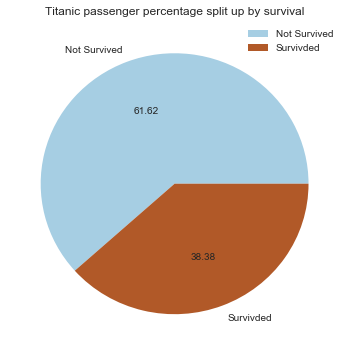

In [9]:
plotpie_by_survival = passengers_by_survival.plot.pie("PassengerId",
                                                      autopct="%0.2f",
                                                      title="Titanic passenger percentage split up by survival",
                                                      labels=["Not Survived", "Survivded"],
                                                      colormap='Paired',
                                                      stacked=True,
                                                      grid = False,
                                                      figsize=(6,6))
plotpie_by_survival.set_ylabel('')

We observe that over 61% of the passengers i.e a majority did not survive.

### Choosing variables
--------------------------------------
Our main goal in this project is to understand which variables affected survival. There are 8 columns<br>
which we can potentially study (*Age, Pclass, Sex, Name, Sibsp, Parch, Embarked, PassengerId*). Out of<br>
these, *PassengerId* is unique for every passenger and plays no role in affecting the survival of a passenger. 
<br>Similarly,the name of passenger or point of embarkment cannot possibly affect the outcome.  *Sibsp, Parch*<br>
are categorical variables which could be worth paying attention to. But in our opinion,  *Age*, *Pclass* and<br> *Sex*  are the most important variables that could affect survival and in this project we would like to study <br> the dependence of survival on these three variables and some of their combinations.

We first create a function that computes the survival rate of passengers grouped by different variables.

In [10]:
def chance_of_survival(variables):
    '''
    Returns the survival rates for the list of variables
    Args:
        -variables: list with variables to calculate the survival rates, i.e.: ['Sex','Pclass']  
    Return:
        A dataframe with the survival rates
    '''
    return titanic_data.groupby(variables).mean().loc[:,'Survived']

Now we write a function which generates a simple bar plot visualization that representes the survival rates for the variable selected:

In [11]:
def plot_survival(variable):
    data = titanic_data.groupby(variable).mean().reset_index()
    # Documentation: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html
    data.plot(kind='bar',x=variable,y='Survived',legend=True)
    plt.title('Survival Rate for {0}'.format(variable))
    plt.xlabel(variable)
    plt.ylabel('Ratio of passengers who survived')
    plt.show()

## Grouping by Passenger Class
-----------------------------------------------------

Let us understand how class affects survival. Before we understand that, let us first check how many passengers<br> travelled in each class.

In [12]:
passengers_by_pclass = titanic_data.groupby("Pclass").count()
passengers_by_pclass

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Embarked
Pclass,,,,,,,,
1,216,216,216,216,186,216,216,214
2,184,184,184,184,173,184,184,184
3,491,491,491,491,355,491,491,491


Not surprisingly, a good majority people travelled in the third class. 

To visualize the passenger split up by class, let us create a pie chart.

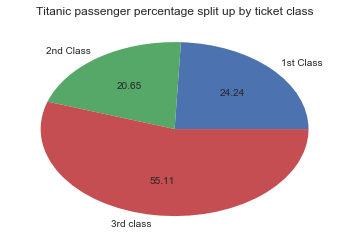

In [13]:
ax = passengers_by_pclass["PassengerId"].plot(kind="pie",
                                              autopct="%.2f",
                                              title ="Titanic passenger percentage split up by ticket class",
                                              labels=["1st Class", "2nd Class", "3rd class"])
ax.set_ylabel('')     

Next we check the survival data among passengers travelling in different classes. 

In [14]:
survival_by_pclass = chance_of_survival("Pclass")
survival_by_pclass

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Let us visualize the survival split up of passengers by the class via a bar chart to get a better understanding.

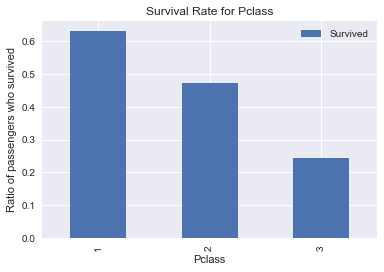

In [15]:
plot_survival("Pclass")

We observe that over 75% of passengers traveling in third class did not survive while over 62% of people traveling in <br>first class survived. *This is perhaps an indication that traveling in third class decreased the likelihood of survival while <br>
first class passengers had a greater likelihood of survival*


## Grouping by Gender
--------------------------------------------------------

Let us now understand how gender affects survival. We first classify passengers by gender and see the percentage <br>split up of passengers by gender.

In [16]:
passengers_by_gender = titanic_data.groupby("Sex").count()
passengers_by_gender

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Embarked
Sex,,,,,,,,
female,314,314,314,314,261,314,314,312
male,577,577,577,577,453,577,577,577


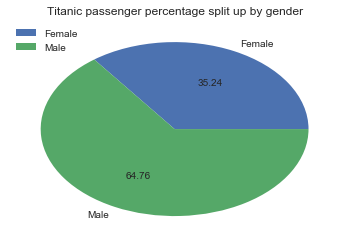

In [17]:
plotpie_by_gender = passengers_by_gender.plot.pie("PassengerId",
                                                  autopct="%0.2f",
                                                  title = "Titanic passenger percentage split up by gender",
                                                  labels=["Female", "Male"])
plotpie_by_gender.set_ylabel('')

About a third of the passengers are female. Let us now look at the survival split up of passengers by gender. 

In [18]:
survival_by_gender = chance_of_survival("Sex")
survival_by_gender

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Almost 75% of female passengers survived while only 19% of male passengers survived.<br>Let us 
visualize the survival split up via a bar chart to get a better understanding. 

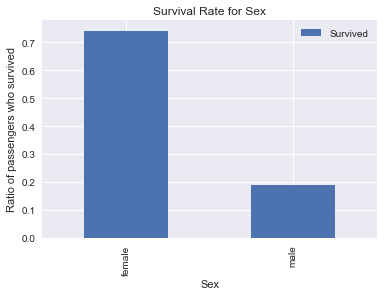

In [19]:
plot_survival("Sex")

As seen before, over 74 % of female passengers survived while over 81% of male passengers did not survive. *This is a strong indication <br>that
the gender of a passenger affected survival*. 

So far we have some evidence that class and gender play a role in survival. To explore the survival dependency on both <br>of them, let us group the survival data by both gender and class.

## Grouping by gender and class
--------------------------------------------------------

In [20]:
#survival_by_gender_and_class = pd.crosstab([titanic_data.Survived.astype(bool)],
                                           #[titanic_data.Sex,titanic_data.Pclass])
survival_by_gender_and_class = chance_of_survival(["Sex","Pclass"])
survival_by_gender_and_class

Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64

Let us now look at a bar plot showing the survival probability for passengers grouped by gender and class.

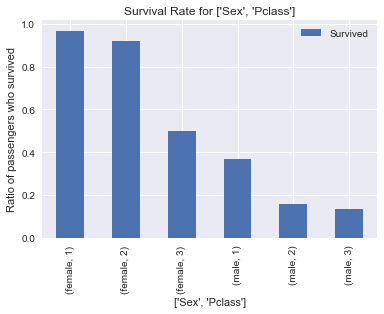

In [21]:
plot_survival(["Sex","Pclass"])

We notice that over 96% of the female first class and over 92% of female second class passengers survived<br> while over 84% of male second class and over 86% of male third class passengers did not survive. This makes <br>our initial hypothesis more credible. 

*We can infer that class and gender do affect survival. Female first and second class passengers have a very high <br>likelihood of survival while male second and third class passengers have a low likelihood of survival.*

## Grouping by Age
----------------------------------------

We now consider whether  age played a role in survival of a passenger and try to observe<br>
any underlying patterns. The resultant analysis will be slightly different compared to before<br>
as age is a continuous variable. Also, recall that the *Age* column had only 714 non missing <br>
out of a possible 891 values. 

Before we begin let us plot a histogram of the non-missing age of passengers and see some statistics.



In [22]:
passengers_by_age = titanic_data["Age"]
passengers_by_age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

The mean age of the passengers was about 30 and the median age was 28. Moreover,<br>
75% of the passengers were under the age of 38, implying a relatively young age<br>
distribution amongst the passengers. The oldest passenger was 80 years old and the <br>
youngest about 5 months old.

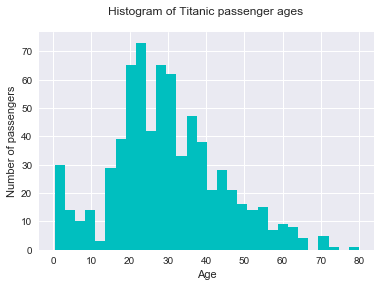

In [23]:
histogram_age = passengers_by_age.plot(kind='hist',
                                  bins=30,
                                  title="Histogram of Titanic passenger ages \n",
                                  color='c')
histogram_age.set_xlabel("Age")
histogram_age.set_ylabel("Number of passengers")

To check the dependence of survival on age, let us compute the point biserial coefficient between the binary variable<br> *Survived* and the continuous variable *Age*. A correlation of 0 implies no correlation while a correlation of +1 or -1<br>
imples a determinative relationship. We will use *scipy* package for this purpose. 

First we remove all entries that have Age value missing  and then compute the <br>
correlation between the remaining *Survived* values and *Age* values.

In [24]:
from scipy import stats
temp = titanic_data[pd.isnull(titanic_data["Age"])==False]
stats.pointbiserialr(np.array(temp["Survived"]),np.array(temp["Age"]))

PointbiserialrResult(correlation=-0.077221094572177656, pvalue=0.039124654013483327)

We get a weak correlation of 0.077 with a p-value of 0.03. (The p-value roughly indicates the probability of an uncorrelated<br> system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets. The<br> p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.)

Next we compute the statistics and plot histograms of passengers' ages grouped
by survival.

In [25]:
age_by_survival=titanic_data.groupby("Survived").Age
age_by_survival.describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
1,290.0,28.343690,14.950952,0.42,19.0,28.0,36.0,80.0


There is not much of a difference in the mean, median and standard deviation of the age of <br>
who did and did not survive. The mean age of survivors is slightly less while the standard deviation is <br>
slightly more. Moreover, the 75th percentile of survivor's age is a little less than that for non-survivors.

Let us now look at a histogram visualization of the passenger's age grouped by survival.

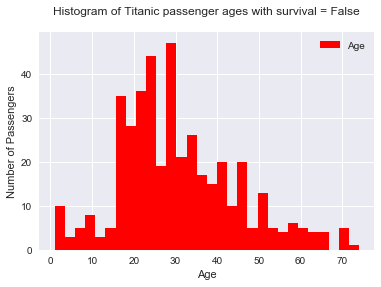

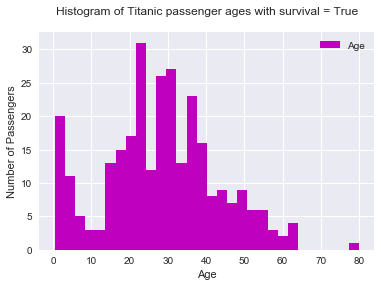

In [26]:
colors=['r','m']
for i,group in age_by_survival:
    temp = group.plot(kind="hist", 
                      title = "Histogram of Titanic passenger ages with survival = " + str(bool(i)) + "\n",
                      legend=True,
                      bins=30,
                      color=colors[i])
    temp.set_xlabel("Age")
    temp.set_ylabel("Number of Passengers")
    plt.figure()

We observe the distribution of age amongst the survivors and non-survivors is quite similar. 

To see if age is a factor in survival, we need to seperate the passengers in to by age categories and look at<br>
survival probability in each age category.

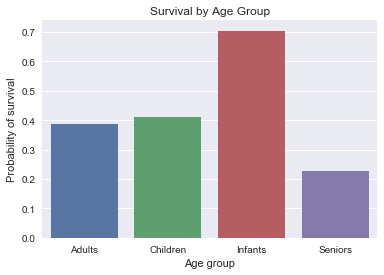

In [27]:
titanic_data["AgeGroup"] = pd.cut(titanic_data["Age"], bins = [0,5,18,60,90], 
                                  labels=['Infants','Children','Adults','Seniors'])
sns.barplot(x="AgeGroup", y="Survived", data=titanic_data,ci=None)
plt.title('Survival by Age Group')
plt.ylabel('Probability of survival')
plt.xlabel('Age group')

Some observations are in order. Amongst infants (0-5 years) we see that about 70 % survive
while more than<br> half of children (5-18 years) and adults (18-60) did not survive. 
Moreover, abut 75 % of seniors did not survive. 

Though age is not a major factor in survival as we saw from the Point biserial test, infants have a high chance<br>
of survival. This can be perhaps attributed to infants getting a priority
during the evacuation procedures. 

Let us go one step further and understand if age and gender together had any effect on survival.
## Grouping by age and gender
----------------------------------------------------

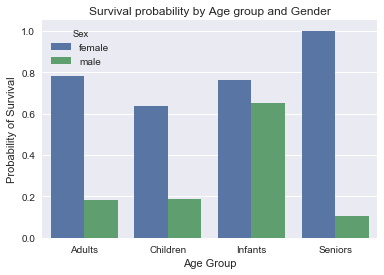

In [28]:
survival_by_age_and_gender = titanic_data.groupby(['AgeGroup','Sex'],as_index=False).mean().loc[:,['AgeGroup','Sex','Survived']]
sns.barplot(x="AgeGroup", y="Survived", hue="Sex", data=survival_by_age_and_gender)
plt.title("Survival probability by Age group and Gender")
plt.xlabel("Age Group")
plt.ylabel("Probability of Survival")

We observe that a good chunk male passengers beyond the age of 5 did not survive while almost all of the female seniors
survived.<br> This can be attributed to female seniors having a greater priority during evacuation.

# Summary
---------------------------------

In this project, we analyzed the survival likelihood of 891 passengers aboard the Titanic.
We concentrated our analysis<br> on Age, Sex and Passenger class and tried to understand if any
of these factors had an effect on survival of passengers. <br> We found out that Gender and class
affected the survival. 

Female first class and second class passengers had a very high chance of survival while male
second and third class<br> passengers had a low likelihood of survival. Age was not
a major factor in survival and the age distribution amongst survivors<br> and non-
survivors was similar. However, infants below the age of 5 and female seniors had a very high chance of survival.<BR> It is likely that we see these trends
because certain groups of passengers recevied higher priority during the evacuation<BR> process
and thus had a higher rate of survival. 

We end by pointing out the limitations of this data analysis. To start off, we note that there is a sample bias. Only the records of<br> 891 passengers aboard the Titanic out of a possible 2224 were analyzed. It is likely that some sort of 
intentional<br> or unintentional bias crept in while selecting the sample thereby causing certain groups of passengers
to be over or under<br> represented. Secondly, we found that quite a few observations were missing. For instance, under the *Age* column, there were<br> substantial number of missing values. This could have had an effect on the conclusions drawn, for example  with respect to<br> *Age* distribution.